In [1]:
import pywt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sc

print(__doc__)

#Do not display warnings
import warnings
warnings.simplefilter('ignore')

# #Inline magic and style
%matplotlib inline
plt.style.use('seaborn-white')

Automatically created module for IPython interactive environment


In [2]:
data = pd.read_csv('C:/Users/shunyinb/OneDrive - Cenovus Energy Inc/Project/09_Kedro/analytics_new/data/01_raw/01_SAGD/B01_P01.csv')
# data = pd.read_csv('C:/Users/shunyinb/OneDrive - Cenovus Energy Inc/Project/09_Kedro/analytics_new/data/01_raw/01_SAGD/B01_P05.csv')
for i in range(1,len(data.columns)):
    data[data.columns[i]] = pd.to_numeric(data[data.columns[i]], errors='coerce') 

In [3]:
data.columns

Index(['Date', 'Gas Co-Injection', 'Injector Bottom Hole Pressure',
       'Steam Injection Valve Position - Outer', 'Steam Flow Rate - Inner',
       'Steam Flow Rate - Outer', 'Wellhead Temperature',
       'Bottom Hole Heel Temperature', 'Emulsion Pressure',
       'Producer Bottom Hole Pressure', 'Pump ESP Current', 'Pump ESP Speed',
       'Emulsion Flow Rate', 'Oil Production', 'Water Production',
       'Casing Gas Temperature', 'Casing Gas Pressure',
       'Casing Gas Valve Position', 'Casing Gas Flow Rate'],
      dtype='object')

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.drop(columns = ['Wellhead Temperature', 'Steam Injection Valve Position - Outer', 'Pump ESP Current', 'Steam Flow Rate - Inner', 'Casing Gas Temperature', 'Casing Gas Pressure', 'Casing Gas Valve Position', 'Casing Gas Flow Rate'])
data = data.iloc[:1399]

data_rollingmedianfill = data.fillna(data.rolling(30, min_periods=1).median())
data_rollingmedianfill = data_rollingmedianfill.fillna(data_rollingmedianfill.median())
data = data_rollingmedianfill.copy()

data.head(50)

,Gas Co-Injection,Injector Bottom Hole Pressure,Steam Flow Rate - Outer,Bottom Hole Heel Temperature,Emulsion Pressure,Producer Bottom Hole Pressure,Pump ESP Speed,Emulsion Flow Rate,Oil Production,Water Production
Date,,,,,,,,,,
2015-01-11,0,2495.888672,258.276733,215.018112,2608.093262,2212.887207,45.148521,417.099518,43.83,99.70
2015-01-12,0,2495.888672,249.286560,212.788620,2592.183838,2217.217773,45.148521,434.335846,138.12,212.46
2015-01-13,0,2495.888672,248.120834,212.102615,2576.625732,2226.160645,45.148521,439.943878,138.42,213.32
2015-01-14,0,2495.888672,251.902237,214.503616,2285.242188,2230.947998,45.148521,420.598206,138.13,212.26
2015-01-15,0,2495.888672,250.346161,214.289246,2381.629150,2221.874268,45.148521,443.032257,135.16,204.48
2015-01-16,0,2500.161377,250.346161,212.016861,2557.583984,2230.847168,45.148521,449.918243,136.33,206.80
2015-01-17,0,2500.161377,250.849182,214.289246,2020.575806,2230.841064,45.148521,415.524658,142.46,211.06
2015-01-18,0,2500.161377,251.902237,214.717987,2499.016602,2235.971924,45.148521,430.153656,135.03,199.88
2015-01-19,0,2500.161377,247.612320,213.002991,2616.151367,2235.964355,45.148521,434.963593,134.12,199.26


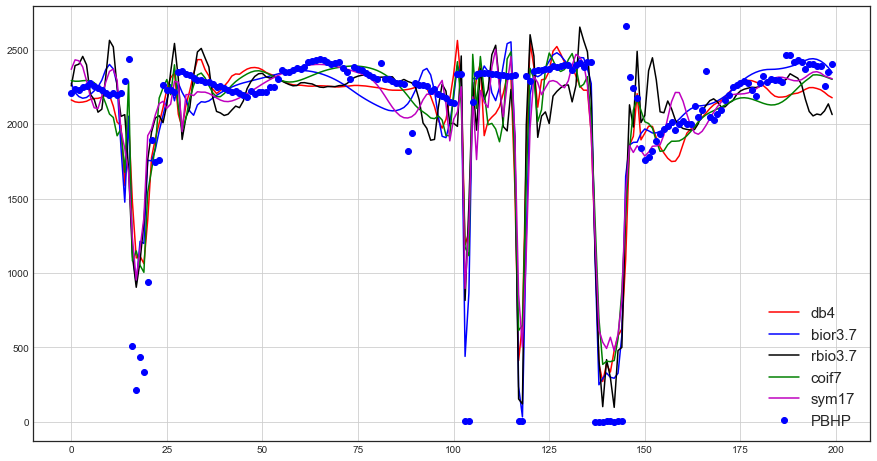

[96861.00608557608, 59253.93614234122, 93745.68981993667, 97249.90582639829, 96431.90983134553]
[0.756749838186478, 0.8511936832250293, 0.7645734321830917, 0.7557731817515793, 0.757827441419124]
bior3.7
3


3

In [7]:
def lowpassfilter(signal, thresh, wavelet):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per", level = 9)
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per")
    return reconstructed_signal, coeff

wavelets = ['db4', 'bior3.7', 'rbio3.7', 'coif7', 'sym17']
colors = ['r', 'b', 'k', 'g', 'm']
all_wavelets_reconstructed_signal = []
all_coeff = []
#  {'b' = blue, 'g' = green, 'r' = red, 'c' = cyan, 'm' = magenta, 'y' = yellow, 'k' = black} = colors

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
all_MSE = []
all_r2_score = []
plt.figure(figsize=(15,8))
for wavelet, color in zip(wavelets, colors):
    reconstructed_signal, coeff = lowpassfilter(data["Producer Bottom Hole Pressure"].values, 0.5, wavelet)
    MSE = mean_squared_error(data["Producer Bottom Hole Pressure"].values, reconstructed_signal[:1399])
    r_squared = r2_score(data["Producer Bottom Hole Pressure"].values, reconstructed_signal[:1399])
    all_MSE.append(MSE)
    all_r2_score.append(r_squared)
    all_wavelets_reconstructed_signal.append(reconstructed_signal)
    all_coeff.append(coeff)
    plt.plot(reconstructed_signal[:1399:7], color, label = wavelet, linewidth=1.5)
plt.plot(data["Producer Bottom Hole Pressure"].values[:1399:7], 'bo', label = 'PBHP')
plt.grid()
plt.legend(loc='best', prop={'size': 15})
plt.show()

print(all_MSE)
print(all_r2_score)
print(wavelets[np.argmax(all_r2_score)])
print(len(all_coeff[2][0]))

x = np.array([[[0,1,2],[0,1,2]],[[0,1,2],[0,1,2]]])
y = x[0]
y.shape[1]

In [197]:
a = []
b = [1, 2]
a = a+b
a = a + [2]

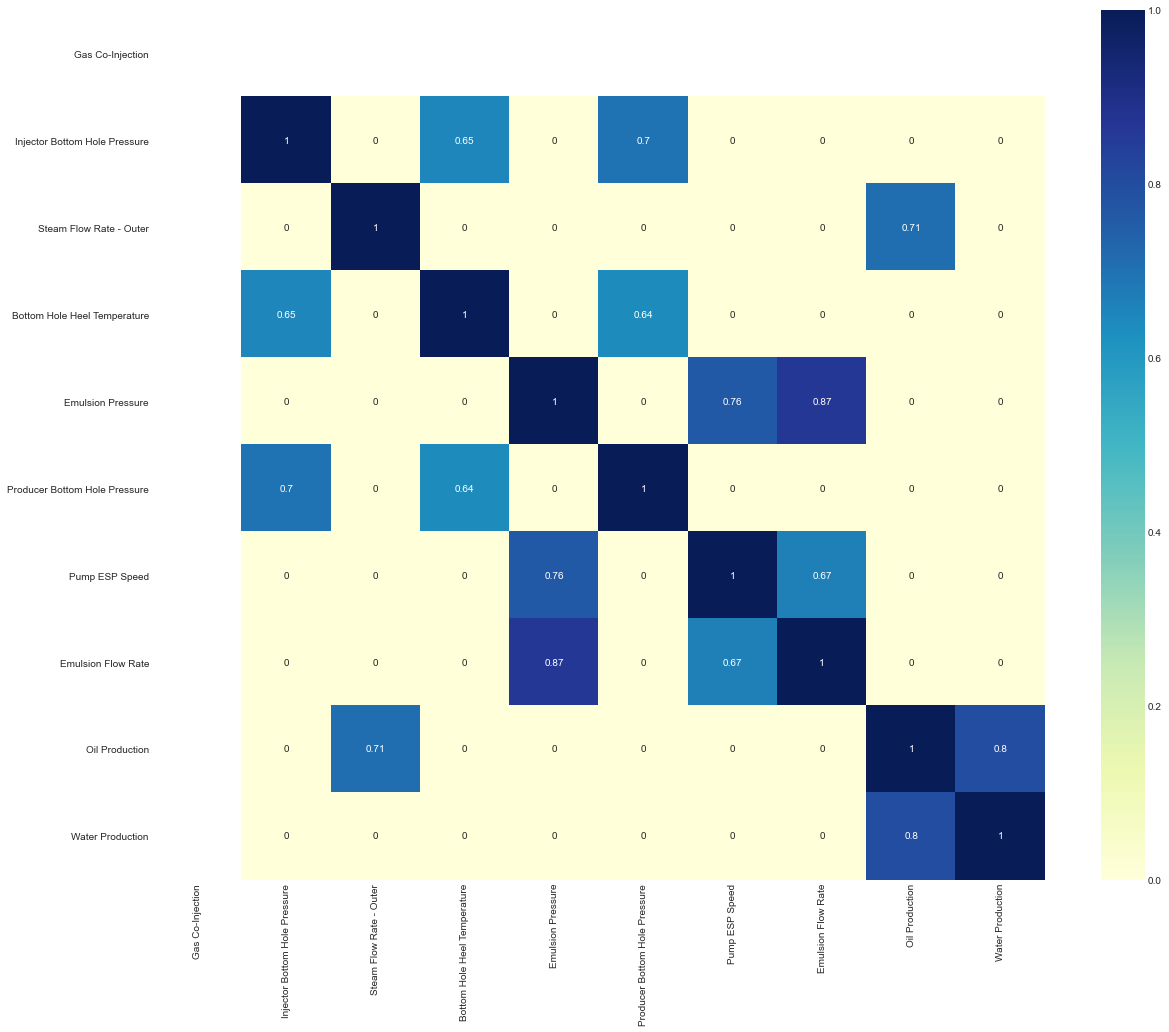

In [58]:
plt.figure(figsize=(20,16))
corr_matrix = data.corr()
corr_matrix[np.abs(corr_matrix) < 0.6] = 0
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu')
plt.show()

In [104]:
data_medianfill = data.fillna(data.median())

data_rollingmeanfill = data.fillna(data.rolling(7, min_periods=1).mean())
data_rollingmeanfill = data_rollingmeanfill.fillna(data_rollingmeanfill.mean())

data_rollingmedianfill = data.fillna(data.rolling(30, min_periods=1).median())
data_rollingmedianfill = data_rollingmedianfill.fillna(data_rollingmedianfill.median())
data_rollingmedianfill.head(50)

,Gas Co-Injection,Injector Bottom Hole Pressure,Steam Flow Rate - Outer,Bottom Hole Heel Temperature,Emulsion Pressure,Producer Bottom Hole Pressure,Pump ESP Speed,Emulsion Flow Rate,Oil Production,Water Production
Date,,,,,,,,,,
2015-01-11,0,2495.888672,258.276733,215.018112,2608.093262,2212.887207,45.148521,417.099518,43.83,99.70
2015-01-12,0,2495.888672,249.286560,212.788620,2592.183838,2217.217773,45.148521,434.335846,138.12,212.46
2015-01-13,0,2495.888672,248.120834,212.102615,2576.625732,2226.160645,45.148521,439.943878,138.42,213.32
2015-01-14,0,2495.888672,251.902237,214.503616,2285.242188,2230.947998,45.148521,420.598206,138.13,212.26
2015-01-15,0,2495.888672,250.346161,214.289246,2381.629150,2221.874268,45.148521,443.032257,135.16,204.48
2015-01-16,0,2500.161377,250.346161,212.016861,2557.583984,2230.847168,45.148521,449.918243,136.33,206.80
2015-01-17,0,2500.161377,250.849182,214.289246,2020.575806,2230.841064,45.148521,415.524658,142.46,211.06
2015-01-18,0,2500.161377,251.902237,214.717987,2499.016602,2235.971924,45.148521,430.153656,135.03,199.88
2015-01-19,0,2500.161377,247.612320,213.002991,2616.151367,2235.964355,45.148521,434.963593,134.12,199.26


In [ ]:
columns_list = ['Steam Flow Rate - Inner',
                'Steam Flow Rate - Outer',
                'Emulsion Flow Rate',
                'Oil Production',
                'Water Production']

for column in columns_list:
    for i in np.arange(len(data_rollingmedianfill)):
        if float(data_rollingmedianfill.loc[i, 'Pump ESP Speed']) = 0:
            float(data_rollingmedianfill.loc[i+1, column]) = 
data_Time

In [75]:
data_rollingmedianfill.isna().sum()

Gas Co-Injection                  0
Injector Bottom Hole Pressure     0
Steam Flow Rate - Outer           0
Bottom Hole Heel Temperature      0
Emulsion Pressure                38
Producer Bottom Hole Pressure     0
Pump ESP Speed                    0
Emulsion Flow Rate               35
Oil Production                    1
Water Production                  1
dtype: int64

In [102]:
df = pd.DataFrame({'B': [0, 1, 2, np.nan, 4]})
df

,B
0,0.0
1,1.0
2,2.0
3,NaN
4,4.0


In [103]:
df.fillna(df.rolling(2, min_periods=1).median())

,B
0,0.0
1,1.0
2,2.0
3,2.0
4,4.0
